In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

# Cargar el dataset
file_path = 'Parkinsons.csv'
df = pd.read_csv(file_path)

# Eliminar columnas innecesarias
df.drop('DoctorInCharge', axis=1, inplace=True)

# Mostrar las primeras filas del conjunto de datos
df = df.round(2)
print(df.head())



   PatientID  Age  Gender  Ethnicity  EducationLevel    BMI  Smoking  \
0       3058   85       0          3               1  19.62        0   
1       3059   75       0          0               2  16.25        1   
2       3060   70       1          0               0  15.37        0   
3       3061   52       0          0               0  15.45        0   
4       3062   87       0          0               1  18.62        0   

   AlcoholConsumption  PhysicalActivity  DietQuality  ...   MoCA  \
0                5.11              1.38         3.89  ...  29.18   
1                6.03              8.41         8.51  ...  12.33   
2                2.24              0.21         6.50  ...  29.93   
3                6.00              1.38         6.72  ...  21.30   
4                9.78              1.19         4.66  ...   8.34   

   FunctionalAssessment  Tremor  Rigidity  Bradykinesia  PosturalInstability  \
0                  1.57       1         0             0                    0  

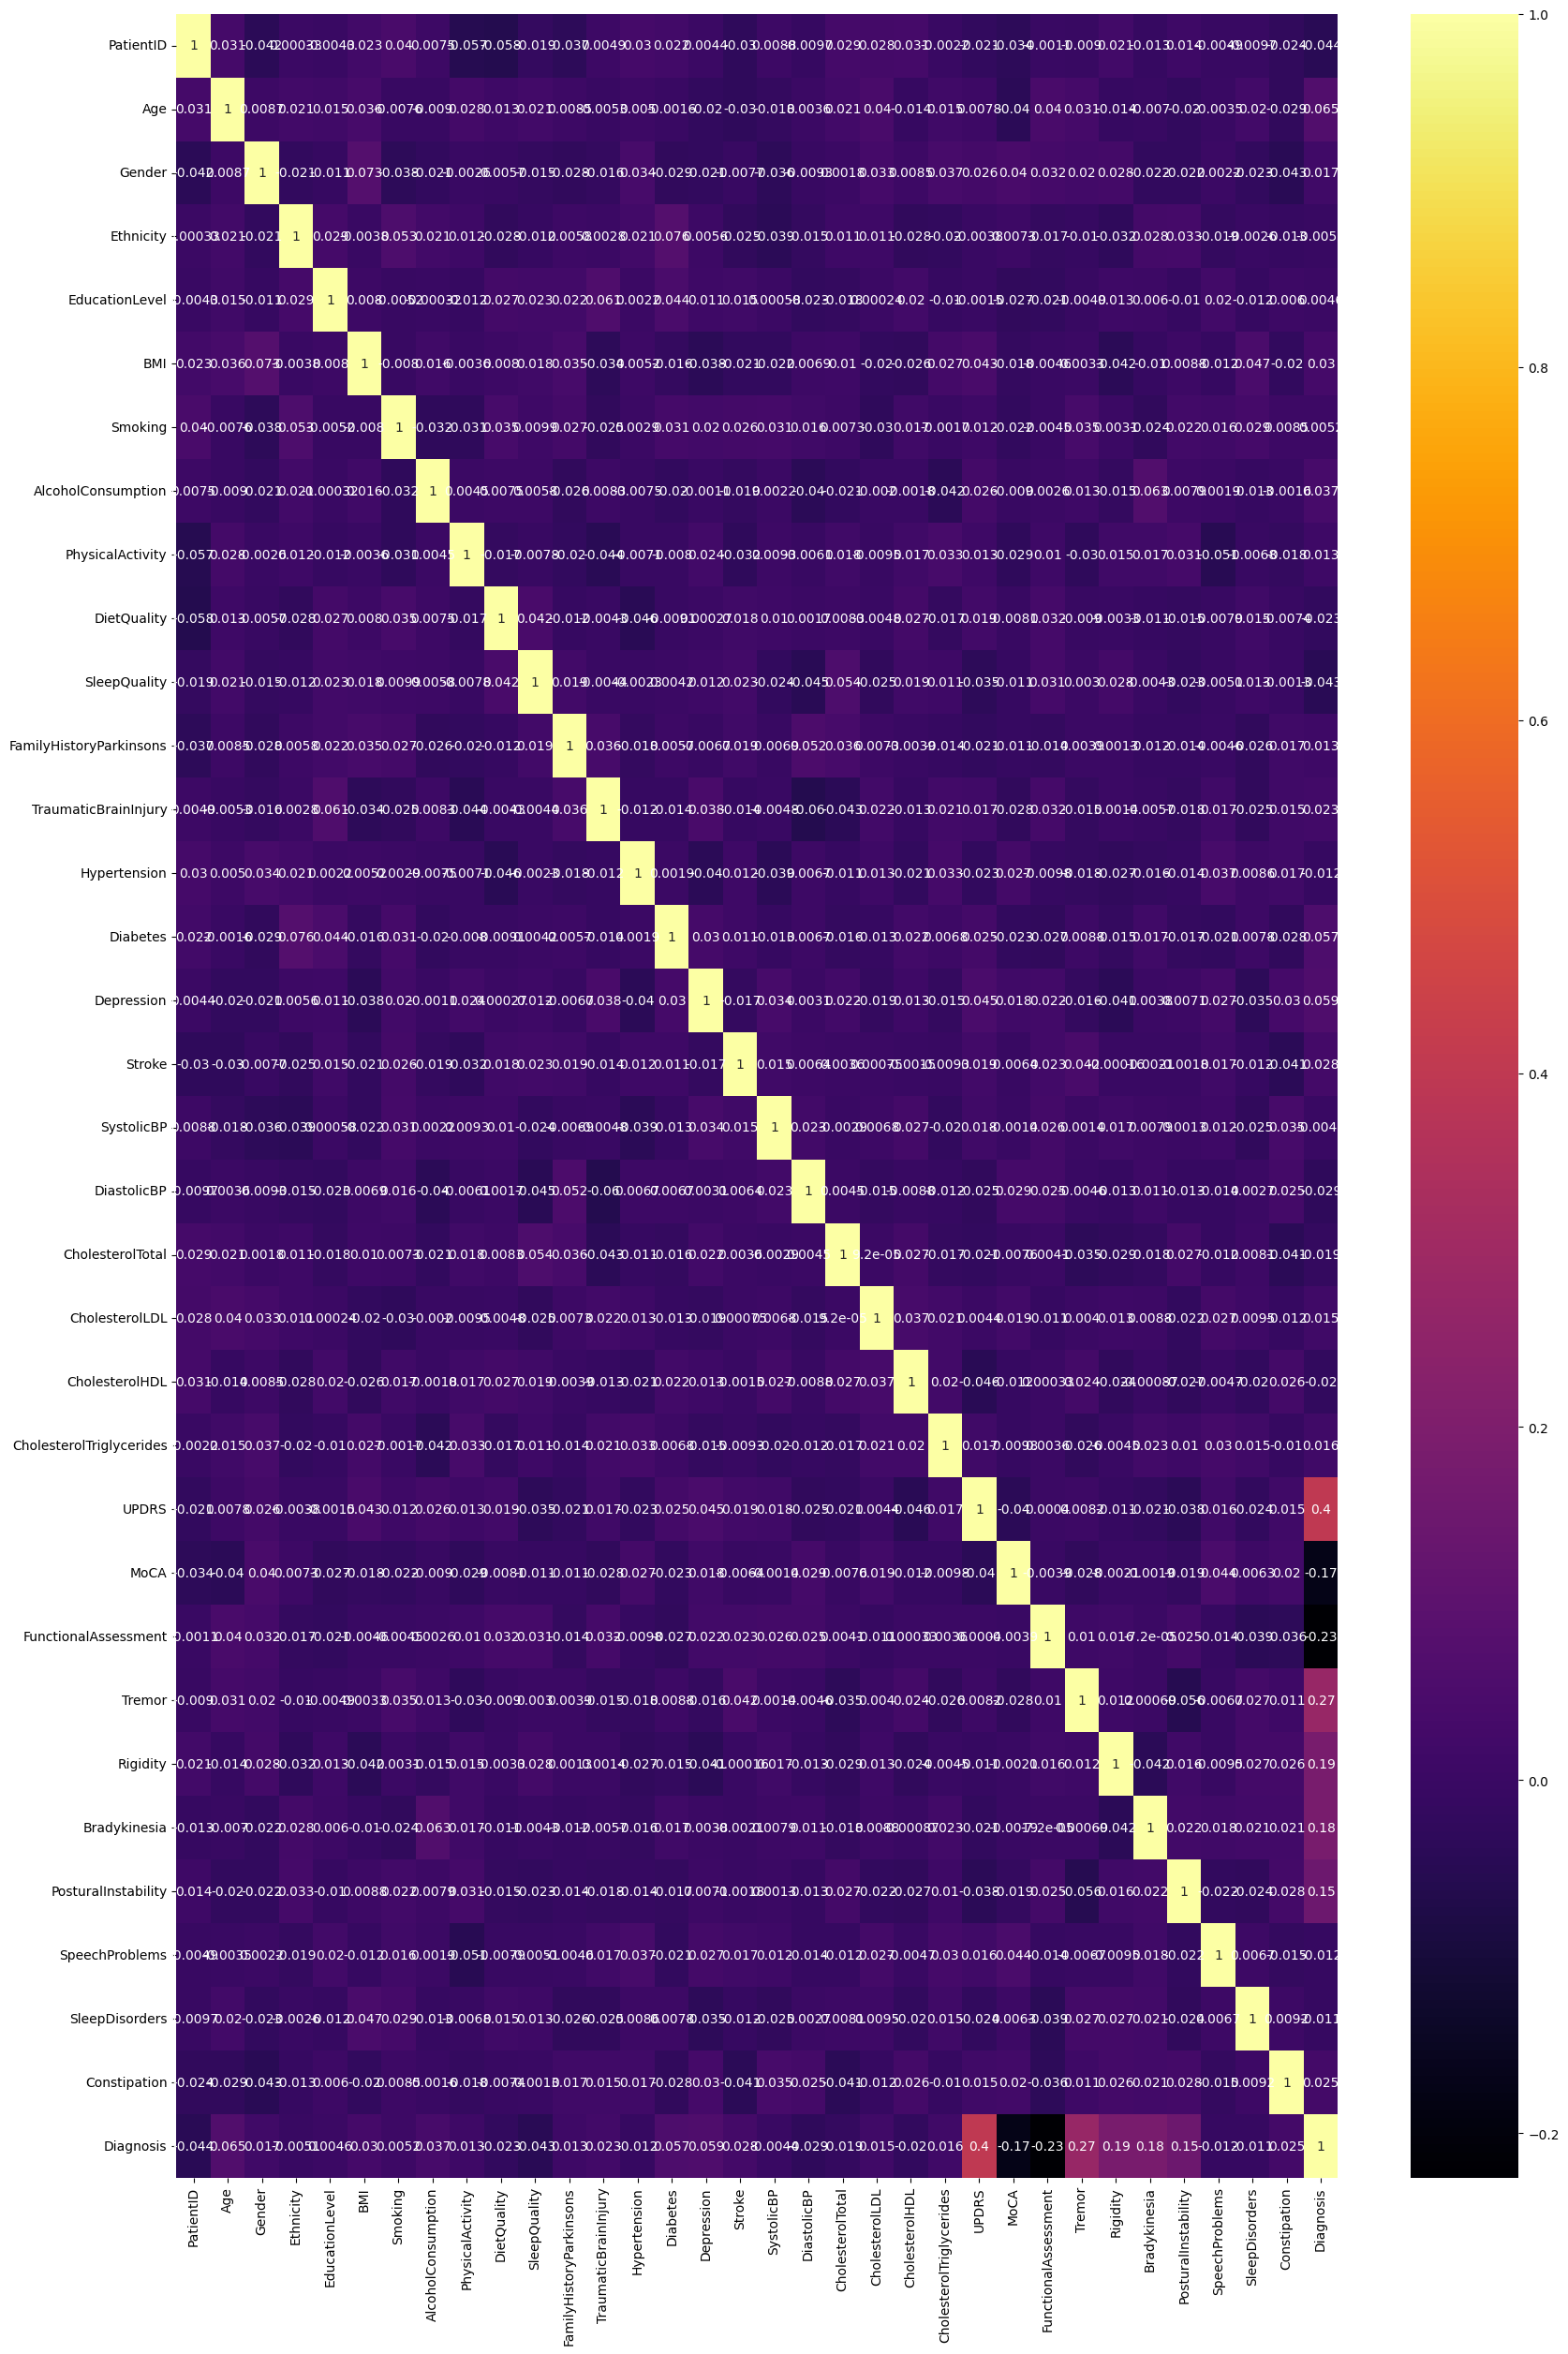

In [ ]:
# Análisis de correlación
correlation_matrix = df.corr()
plt.figure(figsize=(20, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='inferno')
plt.show()


In [ ]:
# Preparación de los datos
data_cleaned = df.drop(columns=['PatientID'])
# data_cleaned = pd.get_dummies(data_cleaned, columns=['Age','FamilyHistoryParkinsons', 'Tremor', 'DietQuality','Gender','Depression','SpeechProblems'], drop_first=True)
data_cleaned = pd.get_dummies(data_cleaned, columns=['Age', 'Rigidity', 'FamilyHistoryParkinsons', 'Tremor', 'SleepDisorders', 'DietQuality', 'Gender','EducationLevel', 'Constipation','PhysicalActivity', 'AlcoholConsumption', 'Smoking', 'Depression', 'SleepQuality'], drop_first=True)

X = data_cleaned.drop(columns=['Diagnosis'])
Y = data_cleaned['Diagnosis']

# Selección inicial de características con SelectKBest
selector = SelectKBest(f_classif, k=25)
X_selected = selector.fit_transform(X, Y)

# Usar una muestra del conjunto de datos para la generación de características polinómicas
X_sample, _, Y_sample, _ = train_test_split(X_selected, Y, train_size=0.1, random_state=42)



In [ ]:
# Crear nuevas características polinómicas
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly_sample = poly.fit_transform(X_sample)

# División del dataset en conjuntos de entrenamiento (80%) y prueba (20%) con características polinómicas
X_train, X_test, Y_train, Y_test = train_test_split(X_poly_sample, Y_sample, test_size=0.2, random_state=42)



In [ ]:
# Estandarizar los datos después de dividir en train/test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Selección de características con RFE
selector = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=10, step=1)
selector = selector.fit(X_train, Y_train)
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)



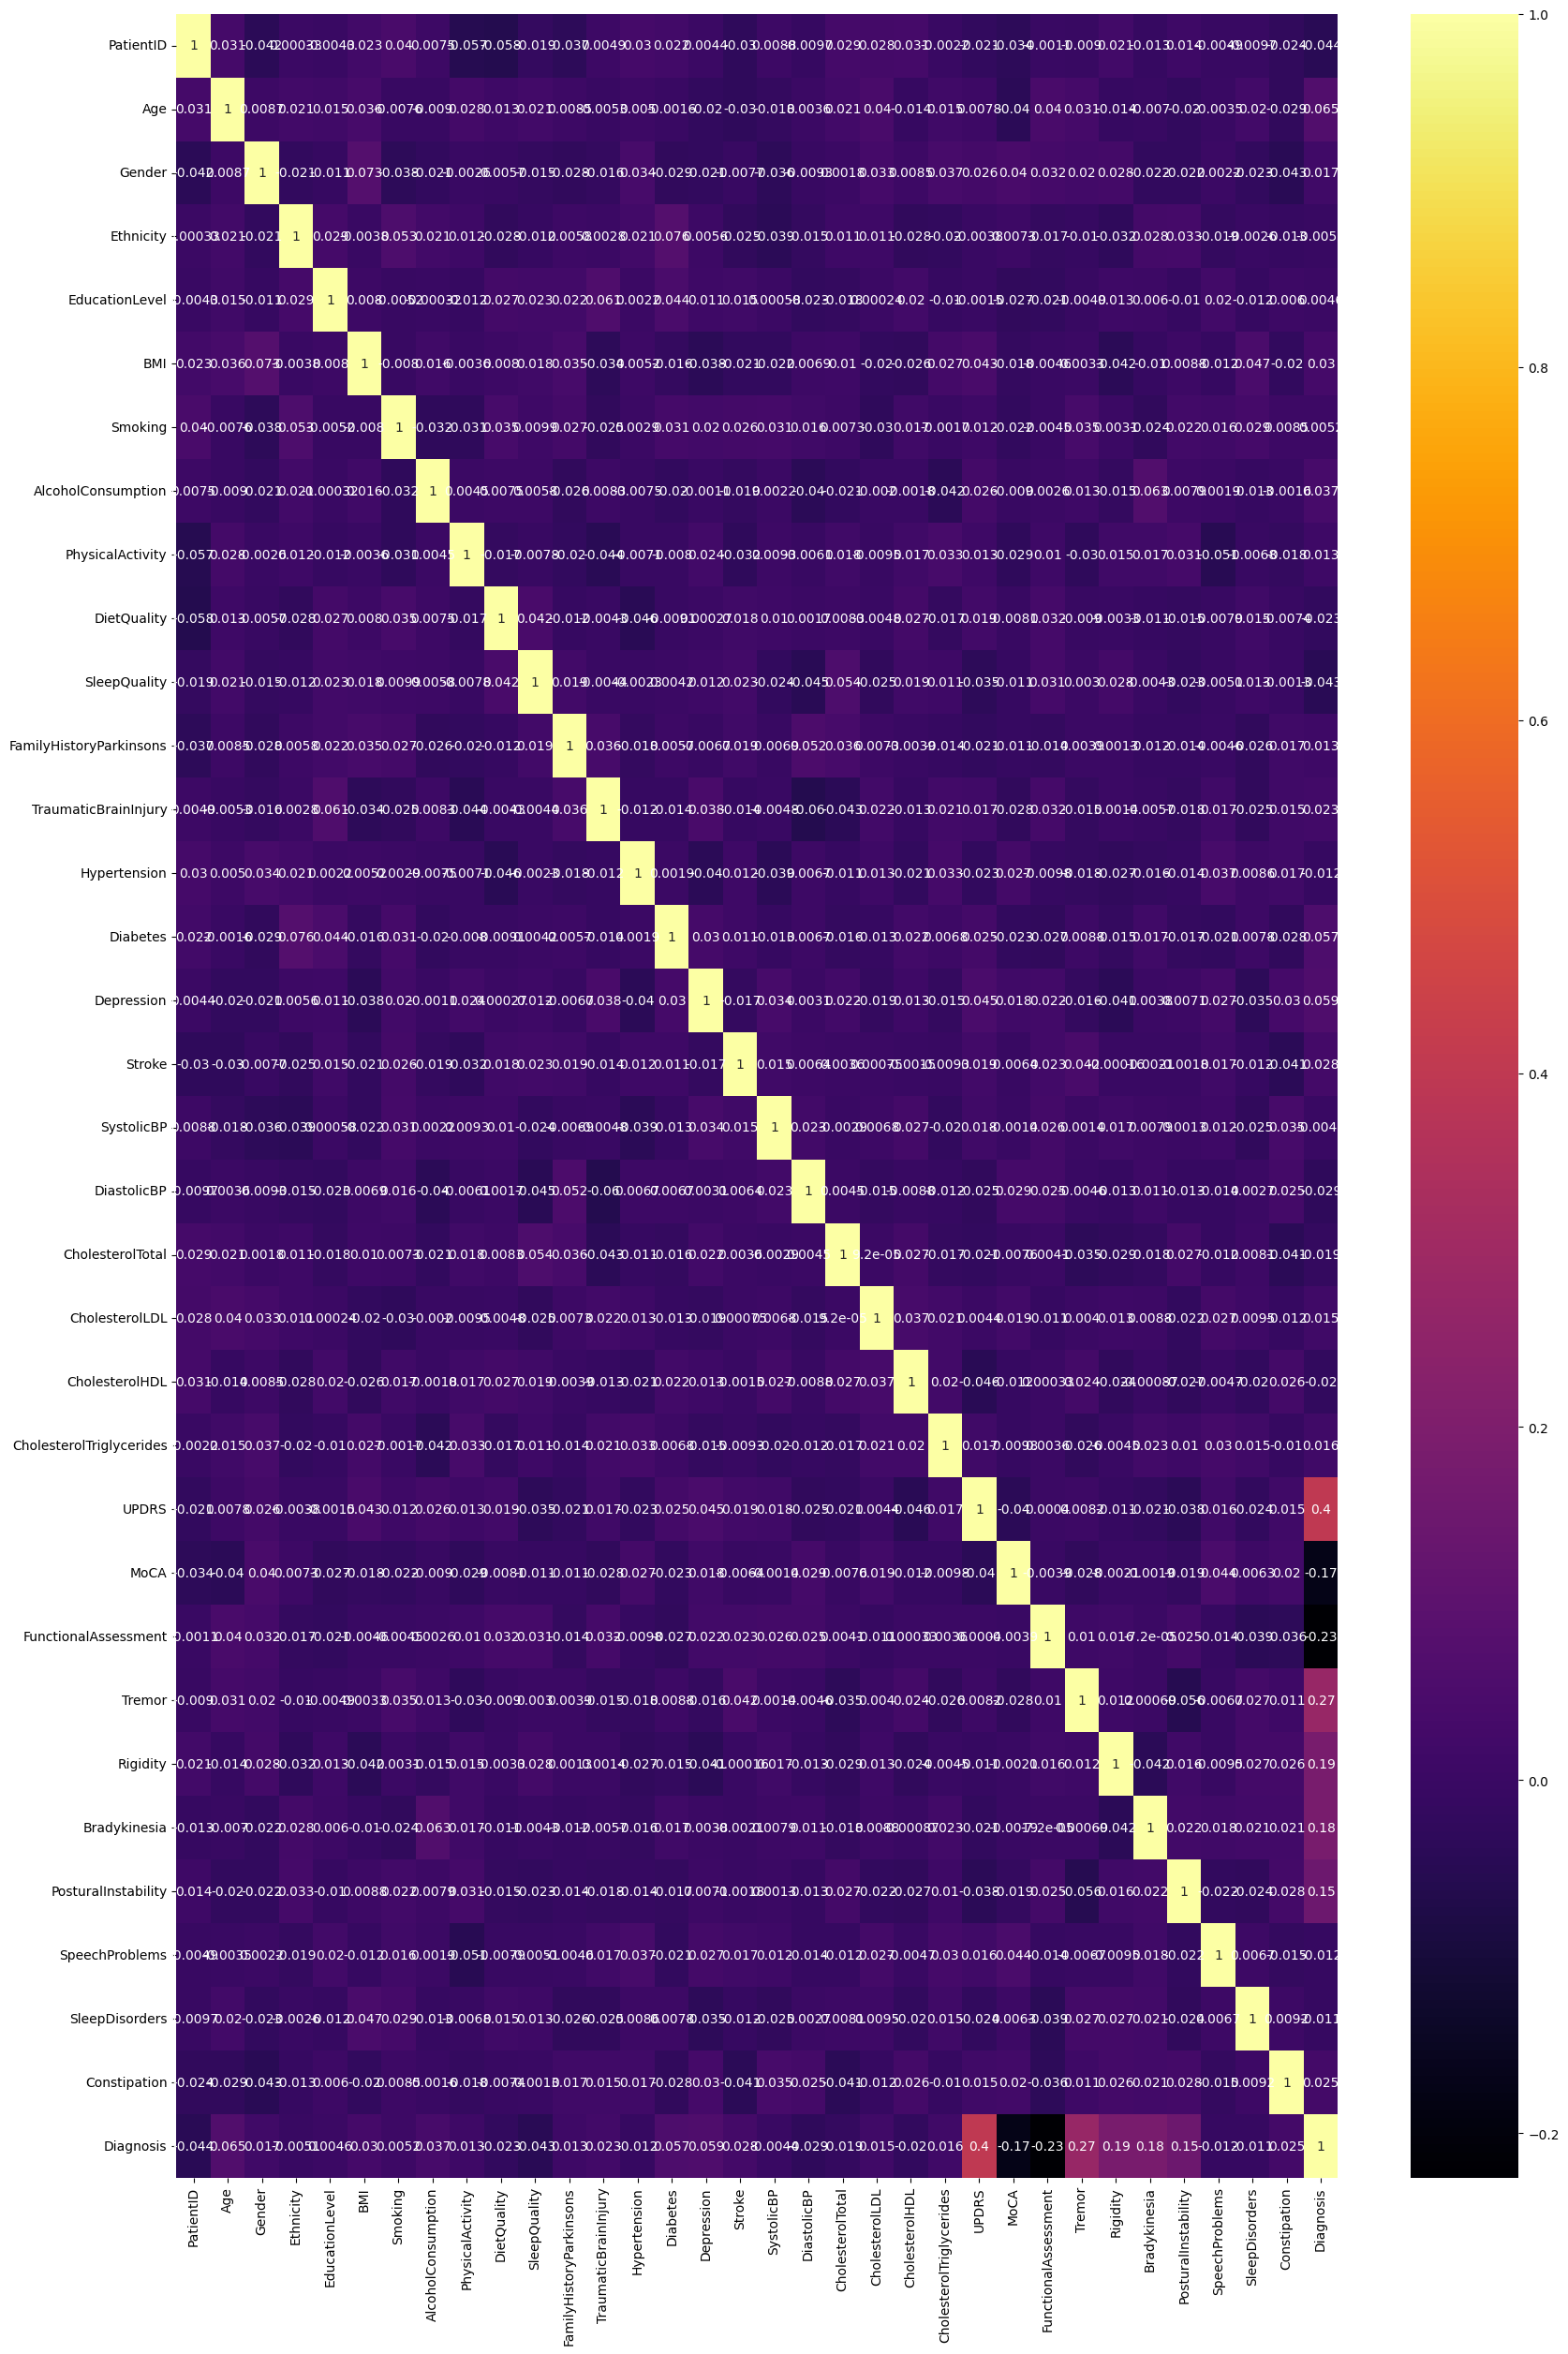

In [ ]:
# Análisis de correlación
correlation_matrix = df.corr()
plt.figure(figsize=(20, 30))
sns.heatmap(correlation_matrix, annot=True, cmap='inferno')
plt.show()



In [ ]:
# Inicializar clasificadores
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC(probability=True),
    'MLP': MLPClassifier(max_iter=400),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'Gradient Boosting': GradientBoostingClassifier()
}



In [ ]:
# Optimización de hiperparámetros con GridSearchCV
param_grid = {
    'Decision Tree': {'max_depth': [3, 5, 7, 10]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'MLP': {'hidden_layer_sizes': [(50,), (100,), (50,50)], 'activation': ['tanh', 'relu']},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_features': ['auto', 'sqrt']},
    'XGBoost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]},
    'Gradient Boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
}

best_classifiers = {}

for name, clf in classifiers.items():
    grid_search = GridSearchCV(clf, param_grid[name], cv=3, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, Y_train)
    best_classifiers[name] = grid_search.best_estimator_
    print(f'Best parameters for {name}: {grid_search.best_params_}')



Best parameters for Decision Tree: {'max_depth': 10}
Best parameters for SVM: {'C': 1, 'kernel': 'linear'}


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLP: {'activation': 'tanh', 'hidden_layer_sizes': (50,)}
Best parameters for Random Forest: {'max_features': 'sqrt', 'n_estimators': 100}
Best parameters for XGBoost: {'learning_rate': 0.01, 'n_estimators': 200}
Best parameters for Gradient Boosting: {'learning_rate': 0.01, 'n_estimators': 200}


In [ ]:
# Ensamblado de modelos
voting_clf = VotingClassifier(estimators=[(name, clf) for name, clf in best_classifiers.items()], voting='soft')
voting_clf.fit(X_train, Y_train)




/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


VotingClassifier(estimators=[('Decision Tree',
                              DecisionTreeClassifier(max_depth=10)),
                             ('SVM',
                              SVC(C=1, kernel='linear', probability=True)),
                             ('MLP',
                              MLPClassifier(activation='tanh',
                                            hidden_layer_sizes=(50,),
                                            max_iter=400)),
                             ('Random Forest', RandomForestClassifier()),
                             ('XGBoost',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            cols...
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('Gradient Boosting',
                              GradientBoostingClassifier(learning_rate=0.01,
                                                         n_estimators=200))],
                 voting='soft')

In [ ]:
# Evaluar el modelo ensamblado
y_pred = voting_clf.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print(f'Precisión del modelo: {accuracy * 100:.2f}%')



Precisión del modelo: 92.86%
